In [72]:
import torch
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertForTokenClassification, Trainer, TrainingArguments, BertTokenizerFast, DataCollatorForTokenClassification
from datasets import Dataset, ClassLabel, Features, Sequence
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

In [74]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

files= ['ramaz.bebiya_culture.jsonl', 'ramaz.bebiya_education.jsonl',
              'ramaz.bebiya_engineering.jsonl','ramaz.bebiya_finance.jsonl', 'ramaz.bebiya_IT.jsonl'
            ]

# Создаем пустой список для хранения всех данных
combined_data = []

# Читаем каждый файл и добавляем его содержимое в combined_data
for file in files:
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            combined_data.append(json.loads(line))

# Сохраняем объединенные данные в один файл
with open('data.jsonl', 'w', encoding='utf-8') as f:
    for entry in combined_data:
        f.write(json.dumps(entry, ensure_ascii=False) + '\n')

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU detected, using CPU.")

GPU detected: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-cased", clean_up_tokenization_spaces=False)

In [4]:
# overlap для сохранения контекста в случае граничного положения некоторых меток
def split_into_chunks(tokens, chunk_size=512, overlap=50): 
    chunks = []
    for i in range(0, len(tokens), chunk_size - overlap):
        chunks.append(tokens[i:i + chunk_size])
    return chunks

In [5]:
def process_data(jsonl_file, chunk_size=512, overlap=50):
    data = []
    with open(jsonl_file, 'r', encoding='utf-8') as file:
        for line in file:
            entry = json.loads(line)
            text = entry['text']
            entities = entry['entities']

            # Токенизация текста
            tokens = tokenizer(
                text, 
                return_offsets_mapping=True, 
                truncation=False, 
                padding=False
            )

            input_ids = tokens['input_ids']
            offset_mapping = tokens['offset_mapping']

            # Разбиение на части
            chunks = split_into_chunks(input_ids, chunk_size, overlap)
            offset_chunks = split_into_chunks(offset_mapping, chunk_size, overlap)

            for chunk, offsets in zip(chunks, offset_chunks):
                labels = ['O'] * len(chunk)
                for start, end, label in entities:
                    entity_started = False
                    for idx, (offset_start, offset_end) in enumerate(offsets):
                        if offset_start >= start and offset_end <= end:
                            if not entity_started:
                                labels[idx] = 'B-' + label
                                entity_started = True
                            else:
                                labels[idx] = 'I-' + label

                data.append({
                    'input_ids': chunk,
                    'attention_mask': [1] * len(chunk),  # маски для каждого токена
                    'labels': labels
                })

    return data

In [75]:
data = process_data('combined_data.jsonl')

In [76]:
for item in data:
    print(item['labels'])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SoftSkills', 'I-SoftSkills', 'I-SoftSkills', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SoftSkills', 'I-SoftSkills', 'I-SoftSkills', 'I-SoftSkills', 'I-SoftSkills', 'I-SoftSkills', 'I-SoftSkills', 'I-SoftSkills', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Knowledge', 'I-Knowledge', 'I-Knowledge', 'I-Knowledge', 'I-Knowledge', 'I-Knowledge', 'I-Knowledge', 'I-Knowledge', 'I-Knowledge', 'I-Knowl

In [8]:
# Cписок меток
label_list = ["O","B-ProgLanguage", "I-ProgLanguage", "B-Tool", "I-Tool", "B-SoftSkills", "I-SoftSkills", "B-Knowledge", "I-Knowledge"]

# Конвертация меток
label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for idx, label in enumerate(label_list)}

In [9]:
def prepare_datasets(data):

    def encode_labels(labels):
        return [label2id.get(label, label2id["O"]) for label in labels]

    data_dict = {
        'input_ids': [item['input_ids'] for item in data],
        'attention_mask': [item['attention_mask'] for item in data],
        'labels': [encode_labels(item['labels']) for item in data]
    }
    
    features = Features({
        'input_ids': Sequence(feature='int32'),
        'attention_mask': Sequence(feature='int32'),
        'labels': Sequence(ClassLabel(num_classes=len(label_list), names=label_list))
    })

    return data_dict, features

In [10]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [11]:
train_data_dict, features = prepare_datasets(train_data)
test_data_dict, _ = prepare_datasets(test_data)

In [12]:
# Преобразование данных в формат Dataset
train_dataset = Dataset.from_dict(train_data_dict)

test_dataset = Dataset.from_dict(test_data_dict)

Я использовал предобученную модель BERT.

Была попытка учесть сильный дисбаланс классов ('O' занимает 1,41 млн из примерно 1,6 млн всех меток), но время обучения модели увеличилось в 7-8 раз. Я решил отказаться от такого неэффективного способа.

In [13]:
model = BertForTokenClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(label_list), id2label=id2label, label2id=label2id)

model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [22]:
# Параметры обучения
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=4, # Ставил 8; обучение было медленным + видеокарте не хватало памяти
    per_device_eval_batch_size=4,  
    gradient_accumulation_steps = 2,
    num_train_epochs=3,
    weight_decay=0.01,    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [23]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [24]:
import evaluate

seqeval = evaluate.load("seqeval")

In [25]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for l in label if l != -100]
        for label in labels
    ]
   
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [27]:
trainer.train()

  0%|          | 0/3510 [00:00<?, ?it/s]d:\python\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
 14%|█▍        | 500/3510 [05:20<31:42,  1.58it/s]

{'loss': 0.4141, 'grad_norm': 7.233827590942383, 'learning_rate': 1.7150997150997152e-05, 'epoch': 0.43}


 28%|██▊       | 1000/3510 [10:46<27:42,  1.51it/s]

{'loss': 0.3499, 'grad_norm': 1.9332685470581055, 'learning_rate': 1.4301994301994305e-05, 'epoch': 0.85}


                                                   
 33%|███▎      | 1170/3510 [14:56<24:01,  1.62it/s]

{'eval_loss': 0.3206522464752197, 'eval_precision': 0.5090425168907391, 'eval_recall': 0.44751762411879403, 'eval_f1': 0.4763014638974474, 'eval_accuracy': 0.9078202718753959, 'eval_runtime': 139.1394, 'eval_samples_per_second': 28.827, 'eval_steps_per_second': 7.209, 'epoch': 1.0}


 43%|████▎     | 1500/3510 [18:36<22:17,  1.50it/s]   

{'loss': 0.3137, 'grad_norm': 0.9459418058395386, 'learning_rate': 1.1452991452991454e-05, 'epoch': 1.28}


 57%|█████▋    | 2000/3510 [24:04<16:33,  1.52it/s]

{'loss': 0.3224, 'grad_norm': 2.052553653717041, 'learning_rate': 8.603988603988605e-06, 'epoch': 1.71}


                                                   
 67%|██████▋   | 2340/3510 [30:05<11:46,  1.66it/s]

{'eval_loss': 0.31186094880104065, 'eval_precision': 0.5348837209302325, 'eval_recall': 0.45744712764361783, 'eval_f1': 0.4931440398421835, 'eval_accuracy': 0.9097639331615205, 'eval_runtime': 138.8263, 'eval_samples_per_second': 28.892, 'eval_steps_per_second': 7.225, 'epoch': 2.0}


 71%|███████   | 2500/3510 [31:54<11:04,  1.52it/s]   

{'loss': 0.3075, 'grad_norm': 1.0521113872528076, 'learning_rate': 5.7549857549857555e-06, 'epoch': 2.14}


 85%|████████▌ | 3000/3510 [37:22<05:37,  1.51it/s]

{'loss': 0.2935, 'grad_norm': 1.4961631298065186, 'learning_rate': 2.9059829059829063e-06, 'epoch': 2.56}


100%|█████████▉| 3500/3510 [42:50<00:06,  1.52it/s]

{'loss': 0.2945, 'grad_norm': 0.7041674852371216, 'learning_rate': 5.6980056980056986e-08, 'epoch': 2.99}


                                                   
100%|██████████| 3510/3510 [45:19<00:00,  1.65it/s]

{'eval_loss': 0.31128624081611633, 'eval_precision': 0.5171571023560465, 'eval_recall': 0.4760761961901905, 'eval_f1': 0.4957670800662272, 'eval_accuracy': 0.9085855026836133, 'eval_runtime': 139.399, 'eval_samples_per_second': 28.774, 'eval_steps_per_second': 7.195, 'epoch': 3.0}


100%|██████████| 3510/3510 [45:25<00:00,  1.29it/s]

{'train_runtime': 2725.3912, 'train_samples_per_second': 10.301, 'train_steps_per_second': 1.288, 'train_loss': 0.32814032644288155, 'epoch': 3.0}


TrainOutput(global_step=3510, training_loss=0.32814032644288155, metrics={'train_runtime': 2725.3912, 'train_samples_per_second': 10.301, 'train_steps_per_second': 1.288, 'total_flos': 7293867688815456.0, 'train_loss': 0.32814032644288155, 'epoch': 3.0})

100%|██████████| 1003/1003 [02:17<00:00,  7.30it/s]


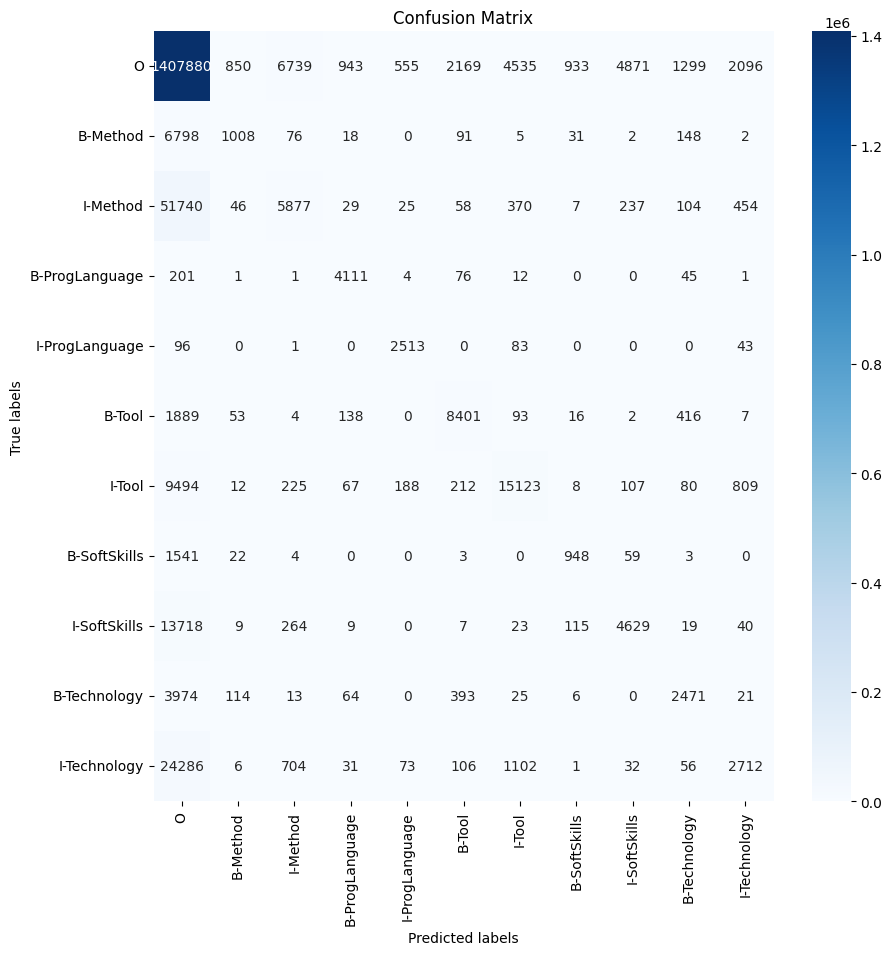

In [28]:
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=2)

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for l in label if l != -100]
    for label in labels
]

flattened_true_labels = [label for sublist in true_labels for label in sublist]
flattened_true_predictions = [label for sublist in true_predictions for label in sublist]

cm = confusion_matrix(flattened_true_labels, flattened_true_predictions, labels=label_list)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)

# Устанавливаем названия и метки осей
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(label_list, rotation=90)
ax.yaxis.set_ticklabels(label_list, rotation=0)

# Показываем график
plt.show()

Из матрицы очень хорошо видно, что модель достаточно точно аннотирует языки программирования по сравнению с остальными сущностями. В принципе неплохо размечена сущность "инструмент".

Можно сказать, что данный итог зависит от того, что языки программирования и инструменты являются конкретными понятиями, которые проще выделять на фоне всего текста. Там отсутвуют слова, которые могут помешать модели определить: это нужное понятие или это обычный текст.

In [29]:
# Сохранение обученной модели
trainer.save_model("./trained_bert_ner_v2")

In [30]:
# Тестирование модели
trainer.evaluate()

100%|██████████| 1003/1003 [02:16<00:00,  7.36it/s]


{'eval_loss': 0.31128624081611633,
 'eval_precision': 0.5171571023560465,
 'eval_recall': 0.4760761961901905,
 'eval_f1': 0.4957670800662272,
 'eval_accuracy': 0.9085855026836133,
 'eval_runtime': 136.6506,
 'eval_samples_per_second': 29.352,
 'eval_steps_per_second': 7.34,
 'epoch': 3.0}